# Adadelta——从零开始

我们在[“RMSProp——从零开始”](rmsprop-gluon.md)一节中描述了，RMSProp针对Adagrad在迭代后期可能较难找到有用解的问题，对小批量随机梯度按元素平方项做指数加权移动平均而不是累加。另一种应对该问题的优化算法叫做Adadelta [1]。有意思的是，它没有学习率超参数。


## Adadelta算法

Adadelta算法也像RMSProp一样，使用了小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}$，并将其中每个元素初始化为0。
给定超参数$\rho$且$0 \leq \rho < 1$，
在每次迭代中，RMSProp首先计算小批量随机梯度$\boldsymbol{g}$，然后对该梯度按元素平方项$\boldsymbol{g} \odot \boldsymbol{g}$做指数加权移动平均，记为$\boldsymbol{s}$：

$$\boldsymbol{s} \leftarrow \rho \boldsymbol{s} + (1 - \rho) \boldsymbol{g} \odot \boldsymbol{g}. $$

然后，计算当前需要迭代的目标函数自变量的变化量$\boldsymbol{g}^\prime$：

$$ \boldsymbol{g}^\prime \leftarrow \frac{\sqrt{\Delta\boldsymbol{x} + \epsilon}}{\sqrt{\boldsymbol{s} + \epsilon}}   \odot \boldsymbol{g}, $$


其中$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-5}$。和Adagrad与RMSProp一样，目标函数自变量中每个元素都分别拥有自己的学习率。上式中$\Delta\boldsymbol{x}$初始化为零张量，并记录$\boldsymbol{g}^\prime$按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x} \leftarrow \rho \Delta\boldsymbol{x} + (1 - \rho) \boldsymbol{g}^\prime \odot \boldsymbol{g}^\prime. $$

同样地，最后的自变量迭代步骤与小批量随机梯度下降类似：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}^\prime. $$


## Adadelta的实现

Adadelta的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
def adadelta(params, sqrs, deltas, rho, batch_size):
    eps_stable = 1e-5
    for param, sqr, delta in zip(params, sqrs, deltas):
        g = param.grad / batch_size
        sqr[:] = rho * sqr + (1 - rho) * g.square()
        cur_delta = ((delta + eps_stable).sqrt()
                     / (sqr + eps_stable).sqrt() * g)
        delta[:] = rho * delta + (1 - rho) * cur_delta * cur_delta
        param[:] -= cur_delta

## 实验

首先，导入本节中实验所需的包。

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import mxnet as mx
from mxnet import autograd, gluon, nd
import numpy as np
sys.path.append('..')
import utils

实验中，我们依然以线性回归为例。设数据集的样本数为1000，我们使用权重`w`为[2, -3.4]，偏差`b`为4.2的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

我们把算法中变量$\boldsymbol{s}$和$\Delta\boldsymbol{x}$初始化为和模型参数形状相同的零张量。

In [3]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * nd.random.normal(scale=1, shape=y.shape)

# 初始化模型参数。
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    deltas = []
    for param in params:
        param.attach_grad()
        # 把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
        deltas.append(param.zeros_like())
    return params, sqrs, deltas

优化函数`optimize`与[“Adagrad——从零开始”](adagrad-scratch.md)一节中的类似。

In [4]:
net = utils.linreg
squared_loss = utils.squared_loss

def optimize(batch_size, rho, num_epochs, log_interval):
    [w, b], sqrs, deltas = init_params()
    y_vals = [squared_loss(net(X, w, b), y).mean().asnumpy()]
    for epoch in range(1, num_epochs + 1):
        for batch_i, (features, label) in enumerate(
            utils.data_iter(batch_size, num_examples, X, y)):
            with autograd.record():
                output = net(features, w, b)
                loss = squared_loss(output, label)
            loss.backward()
            adadelta([w, b], sqrs, deltas, rho, batch_size)
            if batch_i * batch_size % log_interval == 0:
                y_vals.append(squared_loss(net(X, w, b), y).mean().asnumpy())
    print('w:', w, '\nb:', b, '\n')
    x_vals = np.linspace(0, num_epochs, len(y_vals), endpoint=True)
    utils.semilogy(x_vals, y_vals, 'epoch', 'loss')

最终，优化所得的模型参数值与它们的真实值较接近。

w: 
[[ 2.00013542]
 [-3.39890313]]
<NDArray 2x1 @cpu(0)> 
b: 
[ 4.20055103]
<NDArray 1 @cpu(0)> 



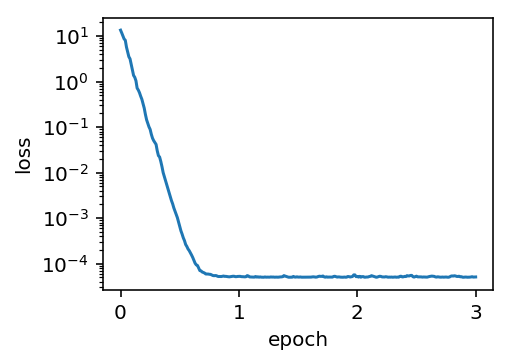

In [5]:
optimize(batch_size=10, rho=0.9999, num_epochs=3, log_interval=10)

## 小结

* Adadelta没有学习率参数。


## 练习

* Adadelta为什么不需要设置学习率超参数？它被什么代替了？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2277)

![](../img/qr_adadelta-scratch.svg)

## 参考文献

[1] Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method. arXiv preprint arXiv:1212.5701.